In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import lax
import argparse
import sys
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats as ss
from utils import *

In [2]:
jax.devices()

[CudaDevice(id=0)]

# Load data

In [3]:
data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"

In [4]:
val_aln_path = f"{data_path}/protein_data/given_validation_alignments.npz"
coord_path = f"{data_path}/protein_data/allCACoord.npz"
given_lddt_path = f"{data_path}/protein_data/pairs_validation_lddts.csv"


nh_path = f"{data_path}/blurry_vec/nHot.npz"
tmat_path = f"{data_path}/blurry_vec/transition_mtx.npy"
jbl_path = f"{data_path}/blurry_vec/jaccard_blosum_int.npy"

## check that databases have same keys and same length sequences

In [5]:
#hot_d; protien_name: L by alphabet size or num bins + 1; encode sequence in alphabet or nhots
#coord_d; protein_name: L by 3; encodes 3D coordinates

In [6]:
coord_d = np.load(coord_path)
oh_d = np.load(nh_path)
bad_list = check_keys_and_lengths(oh_d, coord_d)

in hot_d but not coord_d:
set()
in coord_d but not hot_d:
{'d1o7d.3', 'd1o7d.2'}


In [7]:
n2l_d = make_name_to_length_d(coord_d)

In [8]:
bad_list.append('d1e25a_')
print(bad_list)

['d1o7d.3', 'd1o7d.2', 'd1e25a_']


In [9]:
# load in validation pairs, their alignments and lddt of them (precomputed in organize_val_and_train)
val_aln_d = dict(np.load(val_aln_path))
val_aln_d_new = {}
for key, val in val_aln_d.items():
    val_aln_d_new[tuple(key.split(','))] = val

val_aln_d = val_aln_d_new
val_aln_d_new = {}
given_lddt_d = {}

# Open the CSV file for reading
with open(given_lddt_path, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        a, b, value = row[0], row[1], float(row[2])  # Convert value to float
        given_lddt_d[(a, b)] = value
        
print(len(given_lddt_d.keys()))
check_keys(given_lddt_d, val_aln_d)

1518
all keys match


[]

In [31]:
for key in val_aln_d.keys():
    if key[0] in bad_list or key[1] in bad_list:
        raise ValueError(f"pair {key} is bad and should not be used")

## Sort for better batching

In [10]:
# sort pairs by length of longer protein
pair_max_length_pairs = [(pair, max(n2l_d[pair[0]], n2l_d[pair[1]])) for pair in val_aln_d.keys()]
sorted_keys = sorted(pair_max_length_pairs, key=lambda x: x[1])
sorted_pairs = [key for key, shape in sorted_keys]
pairs = sorted_pairs
given_lddt_list = [given_lddt_d[pair] for pair in pairs]

# Run alignment benchmark

In [11]:
def run_in_batches(long_list, batch_size, params, data):
    result = []
    for i in range(0, len(long_list), batch_size):
        batch = long_list[i:i + batch_size]  # Get the current batch
        result.extend(run_batch(batch, params, data))   # Process and extend results
        print(f"finished batch {i}")
    return result

def run_batch(pairs, params, data):

    oh_d= data["oh_d"]
    blosum = data["blosum"]
    if params["use_two"]:
        oh_d2 = data["oh_d2"]
        blosum2 = data["blosum2"]

    # compute max length of any protein
    names=[item for tup in pairs for item in tup]
    max_len = max([n2l_d[name] for name in names])
    pad_to = int(jnp.where(max_len < 1, 1, 2 ** jnp.ceil(jnp.log2(max_len))))
    #print(pad_to)

    #print(max([oh_d[pair[0]].shape[0] for pair in pairs]))
    # get oh and coords for left and right part of pairs, padded
    lefts, left_lengths = pad_and_stack_manual([oh_d[pair[0]] for pair in pairs],pad_to = pad_to)
    rights, right_lengths = pad_and_stack_manual([oh_d[pair[1]] for pair in pairs], pad_to = pad_to)
    
    if params["use_two"]:
        lefts2, _ = pad_and_stack_manual([oh_d2[pair[0]] for pair in pairs],pad_to = pad_to)
        rights2, _ = pad_and_stack_manual([oh_d2[pair[1]] for pair in pairs], pad_to = pad_to)

    left_coords, _ = pad_and_stack_manual([coord_d[pair[0]] for pair in pairs],pad_to = pad_to)
    right_coords, _ = pad_and_stack_manual([coord_d[pair[1]] for pair in pairs], pad_to = pad_to)

    # make similarity matrices
    if params["blurry"]:
        sim_tensor = vv_sim_mtx_blurry(lefts, rights, blosum)
        sim_tensor = v_replace_jaccard_w_blosum_score(sim_tensor, params["jaccard_blosum"])
    else:
        sim_tensor = vv_sim_mtx(lefts, rights, blosum)
        if params["use_two"]:
            sim_tensor *= params["w1"]
            sim_tensor += params["w2"]*vv_sim_mtx(lefts2, rights2, blosum2)

    # align (gap, open, temp)
    length_pairs = jnp.column_stack([jnp.array(left_lengths), jnp.array(right_lengths)])
    aln_tensor = v_aln_w_sw(sim_tensor, length_pairs, params["gap_extend"], params["gap_open"], params["temp"])
    aln_tensor = (aln_tensor>params["soft_aln_thresh"]).astype(int)

    # compute lddts 
    lddts = vv_lddt(left_coords, right_coords, aln_tensor, jnp.sum(aln_tensor, axis = [-2,-1]), jnp.array(left_lengths))

    return lddts

# Grid search for BV 

## Run for BVs

In [12]:
open_choices = np.arange(-20,0,2)
extend_choices =np.arange(-3,.3,0.5)
print(open_choices)
print(extend_choices)

[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2]
[-3.  -2.5 -2.  -1.5 -1.  -0.5  0. ]


In [13]:
params = {}
params["gap_extend"] = None
params["gap_open"] = None
params["temp"] = 1e-3 # do not change
params["soft_aln_thresh"]=.5 # do not change
params["use_two"]= None
params["w1"] = None
params["w2"] = None
params["blurry"] = True
params["jaccard_blosum"] = np.load(jbl_path) +0.0

In [14]:
%%time
lddt_d = {}

data = {}
data["blosum"] = np.load(tmat_path)
data["oh_d"] = np.load(nh_path)


for o in open_choices:
    for e in extend_choices:
        print(o,e)
        params["gap_extend"] = e
        params["gap_open"] = o
        lddt_d[(o,e)] = run_in_batches(pairs, 100, params, data)

-20 -3.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-20 -2.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-20 -2.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-20 -1.5
finished batch 0
finished batch 100
fini

finished batch 1400
finished batch 1500
-14 -0.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-14 0.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-12 -3.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-12 -2.5
f

finished batch 1300
finished batch 1400
finished batch 1500
-6 -1.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-6 -1.0
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished batch 1500
-6 -0.5
finished batch 0
finished batch 100
finished batch 200
finished batch 300
finished batch 400
finished batch 500
finished batch 600
finished batch 700
finished batch 800
finished batch 900
finished batch 1000
finished batch 1100
finished batch 1200
finished batch 1300
finished batch 1400
finished bat

In [15]:
for key, val in lddt_d.items():
    lddt_d[key]= [_.item() for _ in val]

In [16]:
save_path=f"{data_path}/blurry_vec/BV_lddt_grid.pkl"
pickle.dump(lddt_d, open(save_path, "wb"))

## Plot results

In [17]:
def plot(lddt_d, mode = "mean"):# Example dictionary (replace this with your actual data)
    data_dict = lddt_d

    # Get all unique x (o) and y (e) values
    x_values = sorted(set(o for o, e in data_dict.keys()))
    y_values = sorted(set(e for o, e in data_dict.keys()))

    # Create an empty 2D array to store the median values
    grid = np.zeros((len(y_values), len(x_values)))

    # Fill the grid with the median of the lists
   
    for (o, e), values in data_dict.items():
        if mode == "mean":
            val = np.mean(values)
        elif mode == "median":
            val = np.median(values)
        elif mode == "spearman_lddt":
            val =  ss.spearmanr(values, given_lddt_list).correlation
        elif mode == "spearman_tm":
            val =  ss.spearmanr(values, tm_list).correlation
        elif mode == "geo_mean":
            val=(ss.spearmanr(values, given_lddt_list).correlation*np.mean(values))**(1/2.0)
        x_idx = x_values.index(o)
        y_idx = y_values.index(e)
        grid[y_idx, x_idx] = val
    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(grid, xticklabels=x_values, yticklabels=y_values, cmap='Blues', annot=True)

    # Add labels and title
    plt.xlabel('o values (x-axis)')
    plt.ylabel('e values (y-axis)')
    plt.title(f'{mode} heatmap')

    # Show the plot
    plt.show()

In [19]:
def get_max_key_by_spearman(your_dict):
    return max(your_dict, key=lambda key: ss.spearmanr(your_dict[key], given_lddt_list).correlation)
def get_max_key_by_mean(your_dict):
    return max(your_dict, key=lambda key: np.mean(your_dict[key]))
def get_max_key_by_median(your_dict):
    return max(your_dict, key=lambda key: np.median(your_dict[key]))

In [20]:
#data_path = "/cluster/tufts/pettilab/shared/structure_comparison_data"
#save_path=f"{data_path}/blurry_vec/BV_lddt_grid.pkl"
#lddt_d = pickle.load(open(save_path, "rb"))

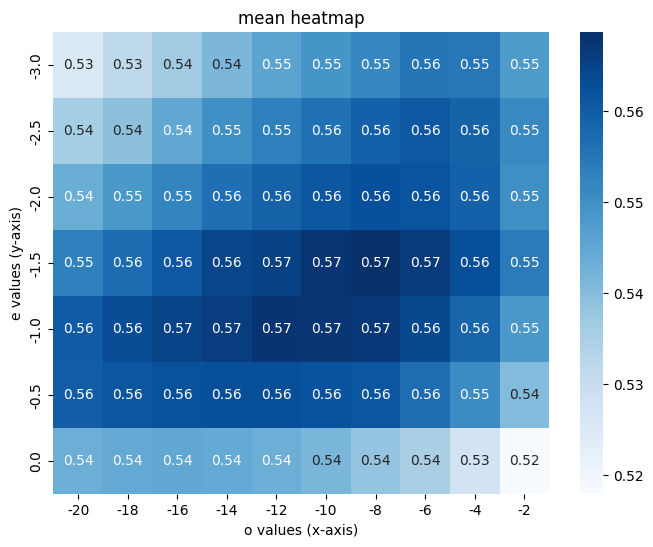

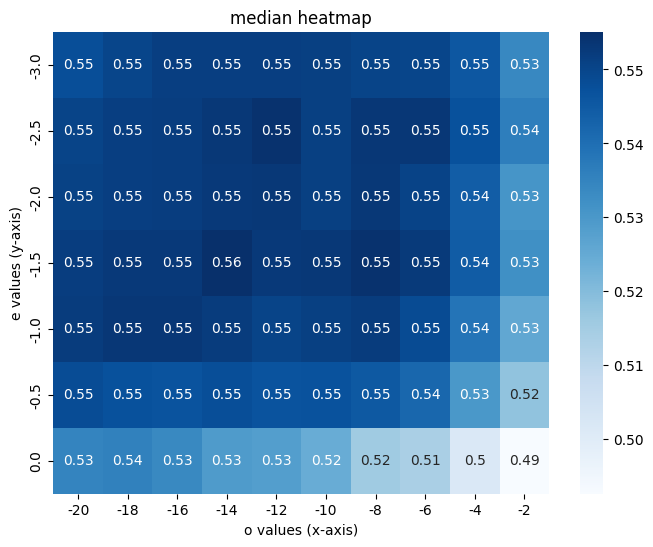

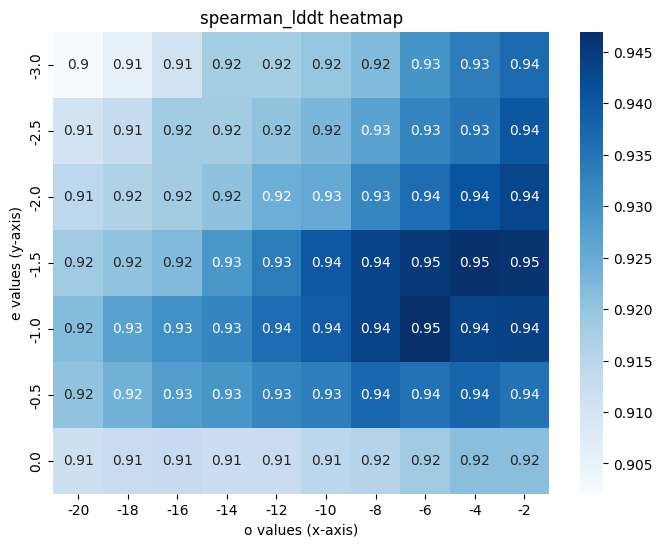

In [22]:
plot(lddt_d, mode = "mean")
plot(lddt_d, mode = "median")
plot(lddt_d, mode = "spearman_lddt")
m_key=get_max_key_by_mean(lddt_d)
med_key=get_max_key_by_median(lddt_d)
s_key = get_max_key_by_spearman(lddt_d)

mean (np.int64(-8), np.float64(-1.5))


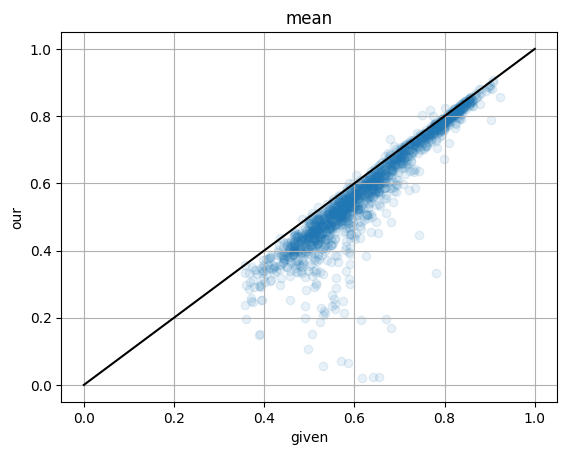

median (np.int64(-14), np.float64(-1.5))


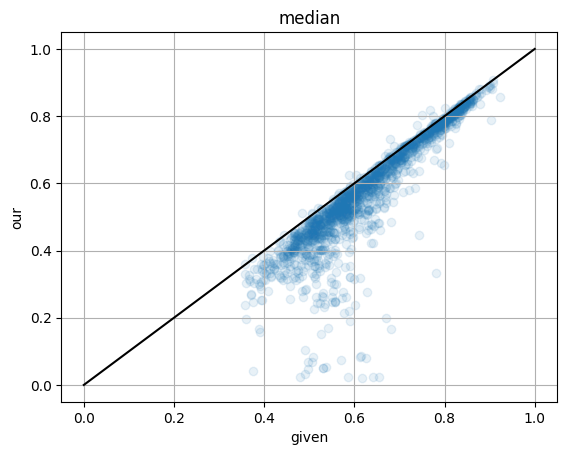

spearman (np.int64(-6), np.float64(-1.0))


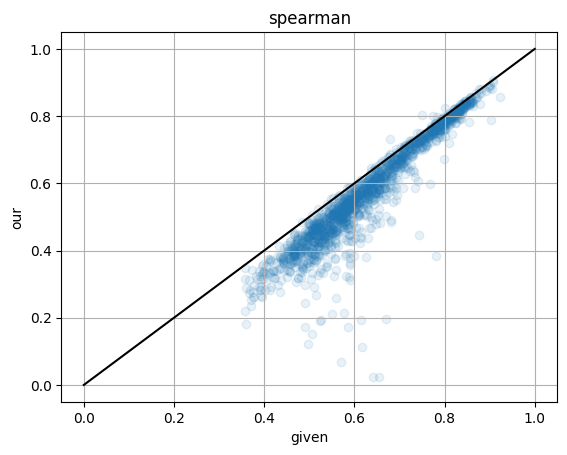

In [28]:
for name, key in [("mean", m_key),("median",med_key),("spearman",s_key)]:
    print(name, key)
    plt.scatter(given_lddt_list, lddt_d[key],alpha = .1)
    plt.xlabel("given")
    plt.ylabel("our")
    plt.title(name)
    plt.plot([0,1],[0,1], color = 'black')
    plt.grid()
    plt.show()


## Write config file for each gap/open and extend